In [33]:
'''
Here, we plot PDGrapher performance as a function of the PPI threshold
Chemical and genetic datasets, random split
'''

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
import sys
sys.path.append('../../')
from constants import *
import os
import numpy as np
from scipy import stats


outdir = 'processed'
os.makedirs(outdir, exist_ok = True)
performance = {}

def add_to_performance(df, cell_line, method_name, performance):
    # Populate the dictionary
    for index, row in df.iterrows():
        metric = row['Metric']
        if metric == 'ranking score':
            metric = 'rankings'
        if cell_line not in performance:
            performance[cell_line] = {}
            
        if metric not in performance[cell_line]:
            performance[cell_line][metric] = {method_name: []}

        values = [row['Fold 1'], row['Fold 2'], row['Fold 3'], row['Fold 4'], row['Fold 5']]
        performance[cell_line][metric][method_name] = values
    return performance

In [34]:
performance = {}

cell_line = 'Chemical'

for th in ['01', '02', '03', '04', '05']:
    df = pd.read_csv('../../../results_metrics_aggregated_bme/sensitivity_ppi/chemical/{}_drugpred_within_best.csv'.format(th))
    df = df[df['Set'] == 'Test']

    method_name = '{}.{}'.format(th[0], th[1])
    performance = add_to_performance(df, cell_line, method_name, performance)
    
cell_line = 'Genetic'

for th in ['01', '02', '03', '04', '05']:
    df = pd.read_csv('../../../results_metrics_aggregated_bme/sensitivity_ppi/genetic/{}_drugpred_within_best.csv'.format(th))
    df = df[df['Set'] == 'Test']

    method_name = '{}.{}'.format(th[0], th[1])
    performance = add_to_performance(df, cell_line, method_name, performance)
    
    

In [35]:
dict_renaming = {'Genetic': 'Genetic-PPI-Breast-MCF7',
                 'Chemical': 'Chemical-PPI-Breast-MDAMB231'}

## Panel partially accurate predictions

/tmp/ipykernel_951812/2653051098.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/2653051098.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/2653051098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


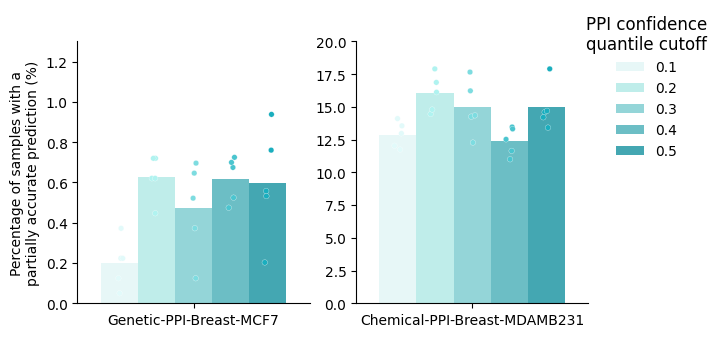

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the data for 'rankings' into a DataFrame
metric = 'percentage of samples with partially accurate predictions'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# Define a color palette that matches the existing figures
palette = {
    '0.1': '#E2FAFA',
    '0.2': '#B0F3F0',
    '0.3': '#7DDCE0',
    '0.4': '#4BC5CF',
    '0.5': '#1AAEBE'
}

# Define the order of methods
method_order = ['0.1', '0.2', '0.3', '0.4', '0.5']

# Separate data into Genetic and Chemical categories
genetic_data = df[df['Cell Line'] == 'Genetic']
chemical_data = df[df['Cell Line'] == 'Chemical']


#Rename cell lines
genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
# Replace x-axis labels with cancer types
genetic_data['Cell Line'] = genetic_data['Cancer Type']
chemical_data['Cell Line'] = chemical_data['Cancer Type']




# Initialize the plot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.35, 3.4), sharey=False)

with sns.plotting_context(plotting_context):
    # Plot Genetic data
    sns.barplot(ax=ax1, data=genetic_data, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)
    sns.stripplot(ax=ax1, data=genetic_data, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=4, edgecolor="white", linewidth=0.2)
    # ax1.set_title('Genetic')
    ax1.set_ylim(0, 1.3)
    ax1.legend_.remove()
    ax1.set_xlabel('')
    ax1.set_ylabel('Percentage of samples with a\npartially accurate prediction (%)')

    # Plot Chemical data
    sns.barplot(ax=ax2, data=chemical_data, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)
    sns.stripplot(ax=ax2, data=chemical_data, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=4, edgecolor="white", linewidth=0.2)
    # ax2.set_title('Chemical')
    ax2.set_ylim(0, 20)
    ax2.set_xlabel('')
    ax2.set_ylabel('')

    # Customize the legend
    handles, labels = ax2.get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    legend = ax2.legend(bar_handles, bar_labels, bbox_to_anchor=(1.25, 1.15), loc='upper center', ncol=1, frameon=False, title='PPI confidence\nquantile cutoff')
    legend.get_title().set_ha('center')

    # Adjust layout
    plt.subplots_adjust(right=0.82)
    sns.despine()
    plt.savefig(osp.join(outdir, 'panel_partially_accurate_pred.pdf'))
    plt.show()


/tmp/ipykernel_951812/3505818240.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/3505818240.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/3505818240.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


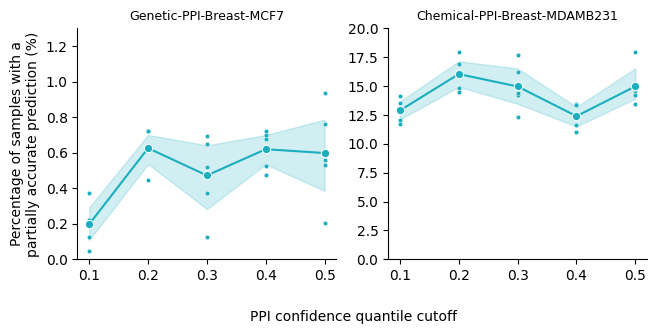

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the data for 'rankings' into a DataFrame
metric = 'percentage of samples with partially accurate predictions'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Ensure Method is treated as a numeric value
df['Method'] = df['Method'].astype(float)

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# Define a color palette that matches the existing figures
palette = {
    0.1: '#E2FAFA',
    0.2: '#B0F3F0',
    0.3: '#7DDCE0',
    0.4: '#4BC5CF',
    0.5: '#1AAEBE'
}

# Separate data into Genetic and Chemical categories
genetic_data = df[df['Cell Line'] == 'Genetic']
chemical_data = df[df['Cell Line'] == 'Chemical']

#Rename cell lines
genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
# Replace x-axis labels with cancer types
genetic_data['Cell Line'] = genetic_data['Cancer Type']
chemical_data['Cell Line'] = chemical_data['Cancer Type']



# Initialize the plot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.35, 3.4), sharey=False)

with sns.plotting_context(plotting_context):
    # Plot Genetic data
    if not genetic_data.empty:
        sns.lineplot(ax=ax1, data=genetic_data, x='Method', y=metric, color=palette[0.5], marker='o', markersize=6)
        sns.scatterplot(ax=ax1, data=genetic_data, x='Method', y=metric, color=palette[0.5], s=10, legend=False)
        # ax1.set_xlabel('PPI confidence quantile cutoff')
        ax1.set_ylabel('Percentage of samples with a\npartially accurate prediction (%)')
        ax1.set_ylim(0, 1.3)
    # Plot Chemical data
    if not chemical_data.empty:
        sns.lineplot(ax=ax2, data=chemical_data, x='Method', y=metric, color=palette[0.5], marker='o', markersize=6)
        sns.scatterplot(ax=ax2, data=chemical_data, x='Method', y=metric, color=palette[0.5], s=10, legend=False)
        # ax2.set_xlabel('PPI confidence quantile cutoff')
        ax2.set_ylabel('')
        ax2.set_ylim(0, 20)

    # Customize the legend
    handles, labels = ax2.get_legend_handles_labels()
    line_handles = handles[:len(method_order)]
    line_labels = labels[:len(method_order)]
    # legend = ax2.legend(line_handles, line_labels, bbox_to_anchor=(1.25, 1.15), loc='upper center', ncol=1, frameon=False, title='PPI confidence\nquantile cutoff')
    legend.get_title().set_ha('center')
    fig.supxlabel('PPI confidence quantile cutoff', fontsize=10)  # Global X-axis title

    ax1.set_title(dict_renaming['Genetic'])  # X-axis title for Genetic
    ax2.set_title(dict_renaming['Chemical'])  # X-axis title for Chemical
    ax1.set_xlabel('')  # X-axis title for Genetic
    ax2.set_xlabel('')  # X-axis title for Genetic

    # Adjust layout
    plt.subplots_adjust(bottom=0.2)
    sns.despine()
    plt.savefig(osp.join(outdir, 'panel_partially_accurate_pred_lineplot.pdf'))
    plt.show()


## Panel ranking

/tmp/ipykernel_951812/2398030245.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/2398030245.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/2398030245.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


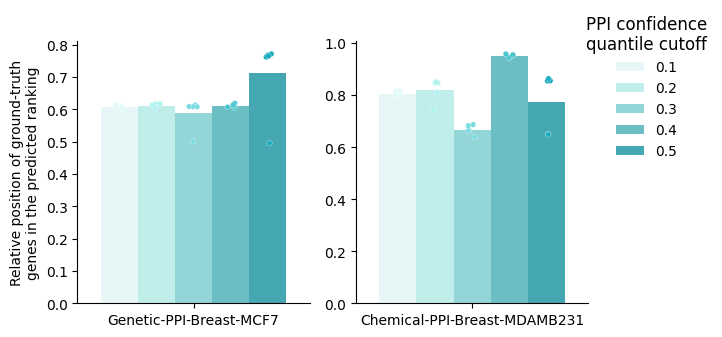

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the data for 'rankings' into a DataFrame
metric = 'rankings'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# Define a color palette that matches the existing figures
palette = {
    '0.1': '#E2FAFA',
    '0.2': '#B0F3F0',
    '0.3': '#7DDCE0',
    '0.4': '#4BC5CF',
    '0.5': '#1AAEBE'
}

# Define the order of methods
method_order = ['0.1', '0.2', '0.3', '0.4', '0.5']

# Separate data into Genetic and Chemical categories
genetic_data = df[df['Cell Line'] == 'Genetic']
chemical_data = df[df['Cell Line'] == 'Chemical']

#Rename cell lines
genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
# Replace x-axis labels with cancer types
genetic_data['Cell Line'] = genetic_data['Cancer Type']
chemical_data['Cell Line'] = chemical_data['Cancer Type']

# Initialize the plot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.35, 3.4), sharey=False)

with sns.plotting_context(plotting_context):
    # Plot Genetic data
    sns.barplot(ax=ax1, data=genetic_data, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)
    sns.stripplot(ax=ax1, data=genetic_data, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=4, edgecolor="white", linewidth=0.2)
    # ax1.set_title('Genetic')
    ax1.legend_.remove()
    ax1.set_xlabel('')
    ax1.set_ylabel('Relative position of ground-truth\ngenes in the predicted ranking')
    # ax1.set_ylim(0,1)
    
    # Plot Chemical data
    sns.barplot(ax=ax2, data=chemical_data, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)
    sns.stripplot(ax=ax2, data=chemical_data, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=4, edgecolor="white", linewidth=0.2)
    # ax2.set_title('Chemical')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    

    # Customize the legend
    handles, labels = ax2.get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    legend = ax2.legend(bar_handles, bar_labels, bbox_to_anchor=(1.25, 1.15), loc='upper center', ncol=1, frameon=False, title='PPI confidence\nquantile cutoff')
    legend.get_title().set_ha('center')

    # Adjust layout
    plt.subplots_adjust(right=0.82)
    sns.despine()
    plt.savefig(osp.join(outdir, 'panel_ranking_2_axes.pdf'))
    plt.show()


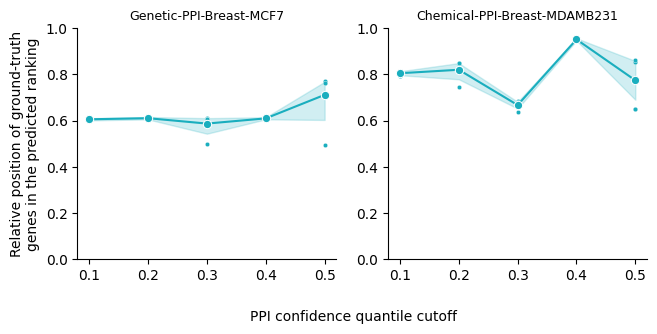

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the data for 'rankings' into a DataFrame
metric = 'rankings'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Ensure Method is treated as a numeric value
df['Method'] = df['Method'].astype(float)

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# Define a color palette that matches the existing figures
palette = {
    0.1: '#E2FAFA',
    0.2: '#B0F3F0',
    0.3: '#7DDCE0',
    0.4: '#4BC5CF',
    0.5: '#1AAEBE'
}

# Separate data into Genetic and Chemical categories
genetic_data = df[df['Cell Line'] == 'Genetic']
chemical_data = df[df['Cell Line'] == 'Chemical']

# Initialize the plot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.35, 3.4), sharey=False)

with sns.plotting_context(plotting_context):
    # Plot Genetic data
    if not genetic_data.empty:
        sns.lineplot(ax=ax1, data=genetic_data, x='Method', y=metric, color=palette[0.5], marker='o', markersize=6)
        sns.scatterplot(ax=ax1, data=genetic_data, x='Method', y=metric, color=palette[0.5], s=10, legend=False)
        # ax1.set_xlabel('PPI confidence quantile cutoff')
        ax1.set_ylabel('Relative position of ground-truth\ngenes in the predicted ranking')
        ax1.set_ylim(0, 1)
    # Plot Chemical data
    if not chemical_data.empty:
        sns.lineplot(ax=ax2, data=chemical_data, x='Method', y=metric, color=palette[0.5], marker='o', markersize=6)
        sns.scatterplot(ax=ax2, data=chemical_data, x='Method', y=metric, color=palette[0.5], s=10, legend=False)
        # ax2.set_xlabel('PPI confidence quantile cutoff')
        ax2.set_ylabel('')
        ax2.set_ylim(0, 1)

    # Customize the legend
    handles, labels = ax2.get_legend_handles_labels()
    line_handles = handles[:len(method_order)]
    line_labels = labels[:len(method_order)]
    # legend = ax2.legend(line_handles, line_labels, bbox_to_anchor=(1.25, 1.15), loc='upper center', ncol=1, frameon=False, title='PPI confidence\nquantile cutoff')
    legend.get_title().set_ha('center')
    fig.supxlabel('PPI confidence quantile cutoff', fontsize=10)  # Global X-axis title
    ax1.set_title(dict_renaming['Genetic'])  # X-axis title for Genetic
    ax2.set_title(dict_renaming['Chemical'])  # X-axis title for Chemical
    ax1.set_xlabel('')  # X-axis title for Genetic
    ax2.set_xlabel('')  # X-axis title for Genetic

    # Adjust layout
    plt.subplots_adjust(bottom=0.2)
    sns.despine()
    plt.savefig(osp.join(outdir, 'panel_ranking_lineplot.pdf'))
    plt.show()


/tmp/ipykernel_951812/2022450934.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


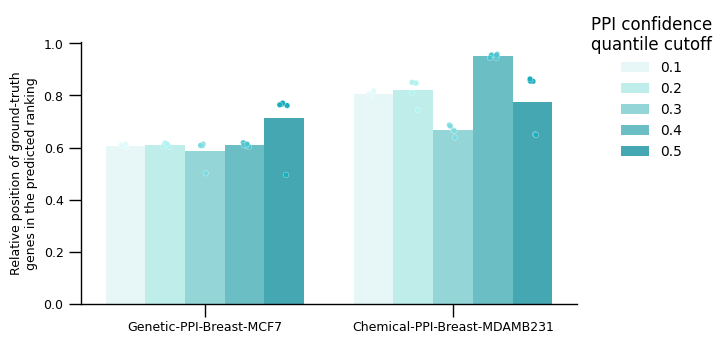

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
metric = 'rankings'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()


df['Cancer Type'] = df['Cell Line'].map(dict_renaming)
df_mean['Cancer Type'] = df_mean['Cell Line'].map(dict_renaming)
# Replace x-axis labels with cancer types
df['Cell Line'] = df['Cancer Type']
df_mean['Cell Line'] = df_mean['Cancer Type']


# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == '0.1'].sort_values(by=metric)
ordered_cell_lines = pdgrapher_means['Cell Line']

#Rename cell lines


# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)


# Define a color palette that matches the existing figures
palette = {
    '0.1': '#E2FAFA',
    '0.2': '#B0F3F0',
    '0.3': '#7DDCE0',
    '0.4': '#4BC5CF',
    '0.5': '#1AAEBE'
}

# Define the order of methods
method_order = ['0.1', '0.2', '0.3', '0.4', '0.5']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(7.35, 3.4))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=4, edgecolor="white", linewidth=0.2)




    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    # plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(1.15, 1.15), loc='upper center', ncol=1, frameon=False, title='PPI confidence\nquantile cutoff')
    plt.subplots_adjust(right=0.8)

    plt.ylabel('Relative position of ground-truth\ngenes in the predicted ranking')
    plt.savefig(osp.join(outdir, 'panel_ranking_1_axis.pdf'))
    plt.show()




## Panels recall@k

/tmp/ipykernel_951812/2682017122.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


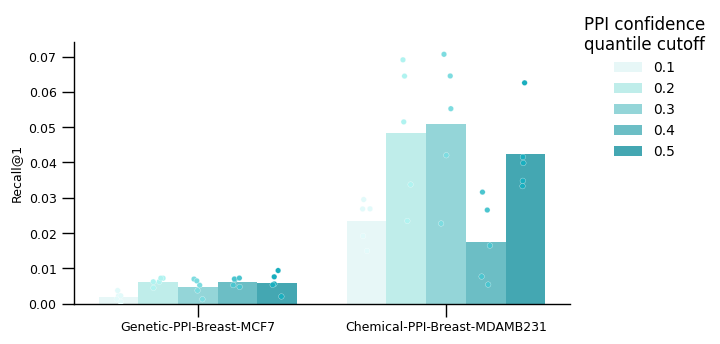

/tmp/ipykernel_951812/2682017122.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


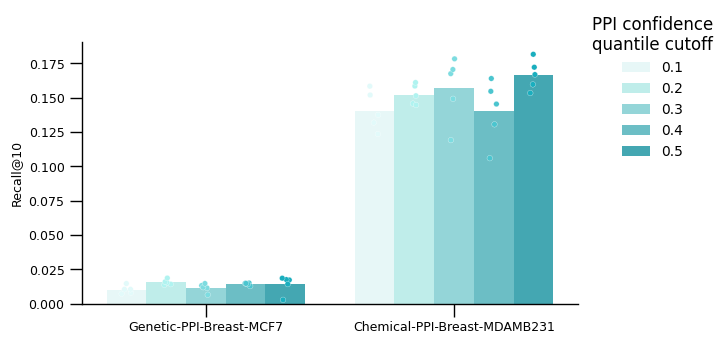

/tmp/ipykernel_951812/2682017122.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


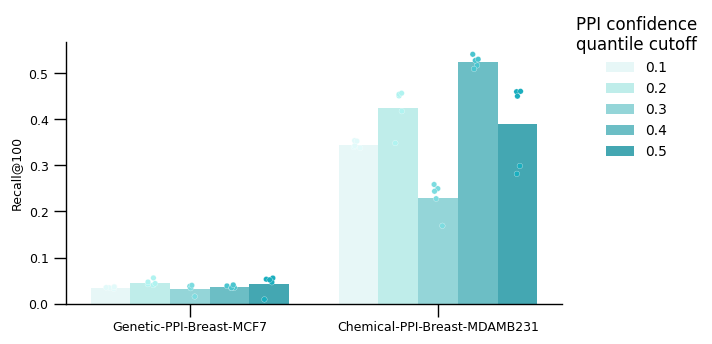

/tmp/ipykernel_951812/2682017122.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


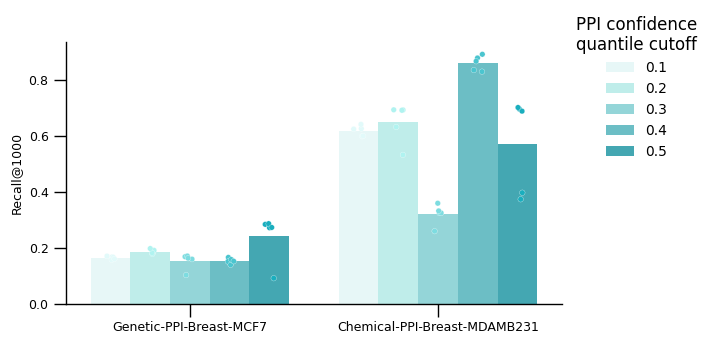

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
for metric in ['recall@1', 'recall@10', 'recall@100', 'recall@1000']:

    data = []
    for cellline, metrics in performance.items():
        if metric in metrics:
            for method, values in metrics[metric].items():
                for value in values:
                    data.append([cellline, method, value])

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

    # Calculate the mean 'rankings' for each cell line and method
    df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()
    df['Cancer Type'] = df['Cell Line'].map(dict_renaming)
    df_mean['Cancer Type'] = df_mean['Cell Line'].map(dict_renaming)
    # Replace x-axis labels with cancer types
    df['Cell Line'] = df['Cancer Type']
    df_mean['Cell Line'] = df_mean['Cancer Type']

    # Order cell lines based on values for PDGrapher
    pdgrapher_means = df_mean[df_mean['Method'] == '0.1'].sort_values(by=metric)
    ordered_cell_lines = pdgrapher_means['Cell Line']

    # Reorder the DataFrame based on ordered cell lines
    df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
    df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)


    # Define a color palette that matches the existing figures
    palette = {
        '0.1': '#E2FAFA',
        '0.2': '#B0F3F0',
        '0.3': '#7DDCE0',
        '0.4': '#4BC5CF',
        '0.5': '#1AAEBE'
    }

    # Define the order of methods
    method_order = ['0.1', '0.2', '0.3', '0.4', '0.5']

    with sns.plotting_context(plotting_context):
        # Initialize the plot
        fig, ax = plt.subplots(figsize=(7.35, 3.4))

        # Create a bar plot for each method
        sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

        # Overlay individual data points
        sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=4, edgecolor="white", linewidth=0.2)




        # Remove title
        plt.title('')
        plt.ylim

        # Remove X-axis label
        plt.xlabel('')
        sns.despine()

        # Adjust legend to only include the bars and place it at the top
        handles, labels = plt.gca().get_legend_handles_labels()
        bar_handles = handles[:len(method_order)]
        bar_labels = labels[:len(method_order)]
        # plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)
        plt.legend(bar_handles, bar_labels, bbox_to_anchor=(1.15, 1.15), loc='upper center', ncol=1, frameon=False, title='PPI confidence\nquantile cutoff')
        plt.subplots_adjust(right=0.8)

        plt.ylabel(metric.capitalize())
        plt.savefig(osp.join(outdir, 'panel_{}_1_axis.pdf'.format(metric)))
        plt.show()




/tmp/ipykernel_951812/2293128974.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/2293128974.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/2293128974.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


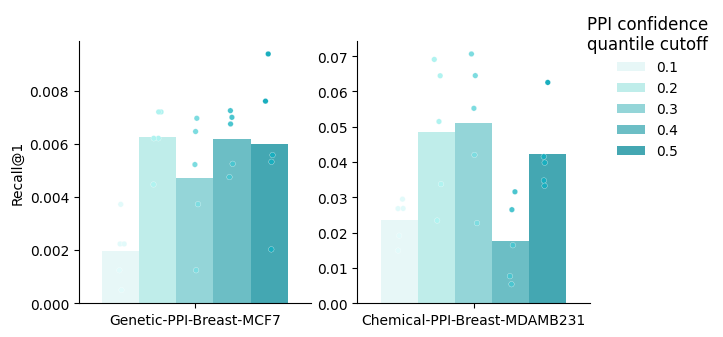

/tmp/ipykernel_951812/2293128974.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/2293128974.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/2293128974.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


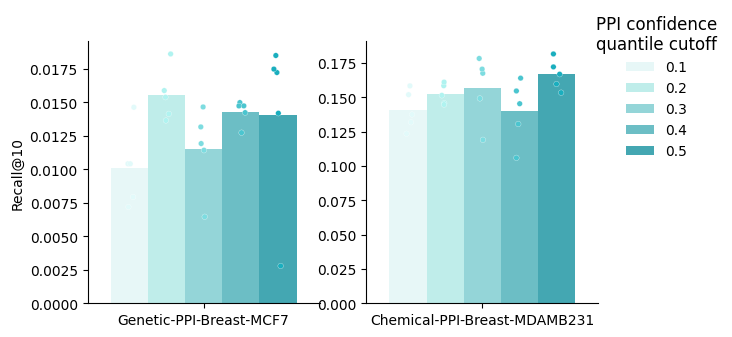

/tmp/ipykernel_951812/2293128974.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/2293128974.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/2293128974.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


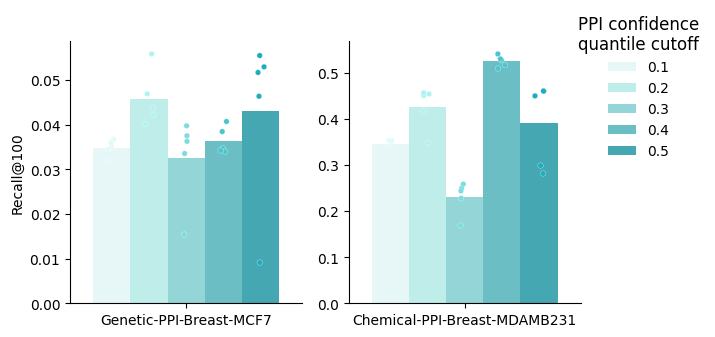

/tmp/ipykernel_951812/2293128974.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/2293128974.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/2293128974.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


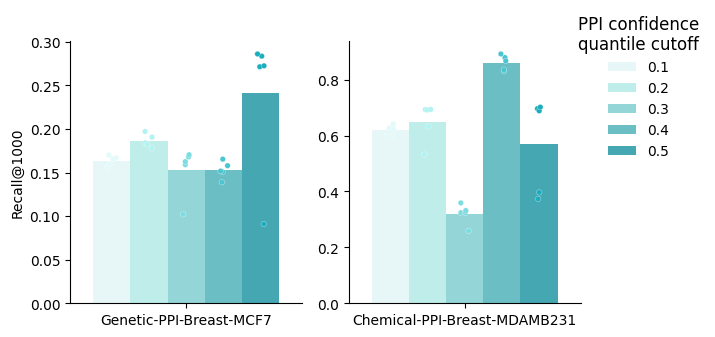

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the data for 'rankings' into a DataFrame
for metric in ['recall@1', 'recall@10', 'recall@100', 'recall@1000']:
    data = []
    for cellline, metrics in performance.items():
        if metric in metrics:
            for method, values in metrics[metric].items():
                for value in values:
                    data.append([cellline, method, value])

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

    # Calculate the mean 'rankings' for each cell line and method
    df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

    # Define a color palette that matches the existing figures
    palette = {
        '0.1': '#E2FAFA',
        '0.2': '#B0F3F0',
        '0.3': '#7DDCE0',
        '0.4': '#4BC5CF',
        '0.5': '#1AAEBE'
    }

    # Define the order of methods
    method_order = ['0.1', '0.2', '0.3', '0.4', '0.5']

    # Separate data into Genetic and Chemical categories
    genetic_data = df[df['Cell Line'] == 'Genetic']
    chemical_data = df[df['Cell Line'] == 'Chemical']
    
    
    #Rename cell lines
    genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
    chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
    # Replace x-axis labels with cancer types
    genetic_data['Cell Line'] = genetic_data['Cancer Type']
    chemical_data['Cell Line'] = chemical_data['Cancer Type']


    # Initialize the plot with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.35, 3.4), sharey=False)

    with sns.plotting_context(plotting_context):
        # Plot Genetic data
        sns.barplot(ax=ax1, data=genetic_data, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)
        sns.stripplot(ax=ax1, data=genetic_data, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=4, edgecolor="white", linewidth=0.2)
        # ax1.set_title('Genetic')
        ax1.legend_.remove()
        ax1.set_xlabel('')
        ax1.set_ylabel(metric.capitalize())
        # ax1.set_ylim(0,1)
        
        # Plot Chemical data
        sns.barplot(ax=ax2, data=chemical_data, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)
        sns.stripplot(ax=ax2, data=chemical_data, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=4, edgecolor="white", linewidth=0.2)
        # ax2.set_title('Chemical')
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        

        # Customize the legend
        handles, labels = ax2.get_legend_handles_labels()
        bar_handles = handles[:len(method_order)]
        bar_labels = labels[:len(method_order)]
        legend = ax2.legend(bar_handles, bar_labels, bbox_to_anchor=(1.25, 1.15), loc='upper center', ncol=1, frameon=False, title='PPI confidence\nquantile cutoff')
        legend.get_title().set_ha('center')

        # Adjust layout
        plt.subplots_adjust(right=0.82)
        sns.despine()
        plt.savefig(osp.join(outdir, 'panel_{}_2_axes.pdf'.format(metric)))
        plt.show()


/tmp/ipykernel_951812/3289711921.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/3289711921.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/3289711921.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


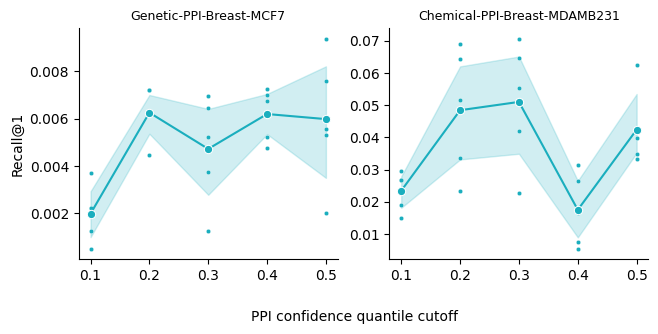

/tmp/ipykernel_951812/3289711921.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/3289711921.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/3289711921.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


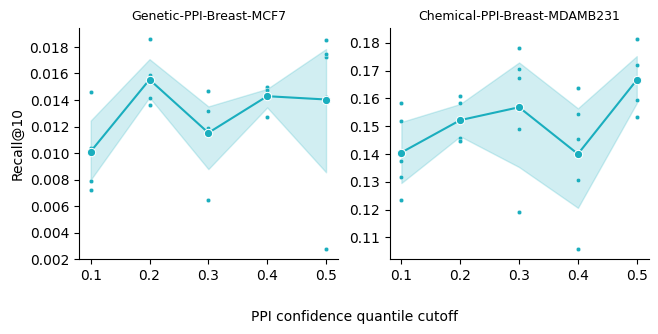

/tmp/ipykernel_951812/3289711921.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/3289711921.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/3289711921.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


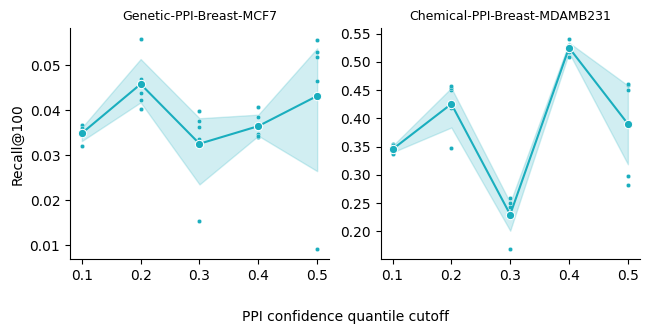

/tmp/ipykernel_951812/3289711921.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/3289711921.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
/tmp/ipykernel_951812/3289711921.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


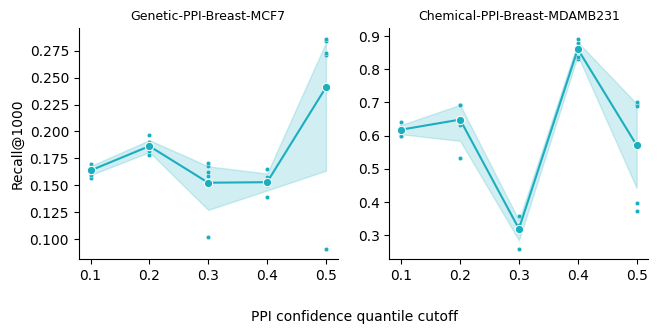

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the data for 'rankings' into a DataFrame
for metric in ['recall@1', 'recall@10', 'recall@100', 'recall@1000']:
    data = []
    for cellline, metrics in performance.items():
        if metric in metrics:
            for method, values in metrics[metric].items():
                for value in values:
                    data.append([cellline, method, value])

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

    # Ensure Method is treated as a numeric value
    df['Method'] = df['Method'].astype(float)

    # Calculate the mean 'rankings' for each cell line and method
    df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

    # Define a color palette that matches the existing figures
    palette = {
        0.1: '#E2FAFA',
        0.2: '#B0F3F0',
        0.3: '#7DDCE0',
        0.4: '#4BC5CF',
        0.5: '#1AAEBE'
    }

    # Separate data into Genetic and Chemical categories
    genetic_data = df[df['Cell Line'] == 'Genetic']
    chemical_data = df[df['Cell Line'] == 'Chemical']

    #Rename cell lines
    genetic_data['Cancer Type'] = genetic_data['Cell Line'].map(dict_renaming)
    chemical_data['Cancer Type'] = chemical_data['Cell Line'].map(dict_renaming)
    # Replace x-axis labels with cancer types
    genetic_data['Cell Line'] = genetic_data['Cancer Type']
    chemical_data['Cell Line'] = chemical_data['Cancer Type']


    # Initialize the plot with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.35, 3.4), sharey=False)

    with sns.plotting_context(plotting_context):
        # Plot Genetic data
        if not genetic_data.empty:
            sns.lineplot(ax=ax1, data=genetic_data, x='Method', y=metric, color=palette[0.5], marker='o', markersize=6)
            sns.scatterplot(ax=ax1, data=genetic_data, x='Method', y=metric, color=palette[0.5], s=10, legend=False)
            # ax1.set_xlabel('PPI confidence quantile cutoff')
            ax1.set_ylabel(metric.capitalize())
            # ax1.set_ylim(0, 0.15)
        # Plot Chemical data
        if not chemical_data.empty:
            sns.lineplot(ax=ax2, data=chemical_data, x='Method', y=metric, color=palette[0.5], marker='o', markersize=6)
            sns.scatterplot(ax=ax2, data=chemical_data, x='Method', y=metric, color=palette[0.5], s=10, legend=False)
            # ax2.set_xlabel('PPI confidence quantile cutoff')
            ax2.set_ylabel('')
            # ax2.set_ylim(0, 0.1)

        # Customize the legend
        handles, labels = ax2.get_legend_handles_labels()
        line_handles = handles[:len(method_order)]
        line_labels = labels[:len(method_order)]
        # legend = ax2.legend(line_handles, line_labels, bbox_to_anchor=(1.25, 1.15), loc='upper center', ncol=1, frameon=False, title='PPI confidence\nquantile cutoff')
        legend.get_title().set_ha('center')
        fig.supxlabel('PPI confidence quantile cutoff', fontsize=10)  # Global X-axis title
        ax1.set_title(dict_renaming['Genetic'])  # X-axis title for Genetic
        ax2.set_title(dict_renaming['Chemical'])  # X-axis title for Chemical
        ax1.set_xlabel('')  # X-axis title for Genetic
        ax2.set_xlabel('')  # X-axis title for Genetic

        # Adjust layout
        plt.subplots_adjust(bottom=0.2)
        sns.despine()
        plt.savefig(osp.join(outdir, 'panel_{}_lineplot.pdf'.format(metric)))
        plt.show()
